In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

# CNN Model

In [2]:
import torch.nn as nn

# Shape layer used for debugging pesky dimensions
# Place in between layers in nn.Sequential to ensure
# things are the shape you expect them to be.
class Shape(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        print(x.shape)
        return x
        
class CNN(nn.Module):
    def __init__(self, out_ch1=32, out_ch2=64, out_ch3=128):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=out_ch1, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            nn.Conv2d(in_channels=out_ch1, out_channels=out_ch2, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            nn.Conv2d(in_channels=out_ch2, out_channels=out_ch3, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            nn.Flatten(1),
            nn.Linear(out_ch3, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.net(x)
        return x # pytorch cross entropy loss function applies softmax to output

# Train

In [27]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def train(X, y, model, epoch=20, batch=16, lr=0.001):
    """Train CNN model. Splits into train/validation sets (10% validation)
    
    Arguments:
    X (ndarray) -- Input data (images)
    y (ndarray) -- Image labels
    epochs (int) -- Number of epochs to train. Default: 20
    batch (int) -- size of batches for the training set. Default: 16
    lr (float) -- learning rate for training. Default: 0.001
    
    Returns:
    None, but prints plots of training/validation loss and accuracy.
    
    """
    torch.manual_seed(0)
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.1)
    trainloader = DataLoader(list(zip(X_train,y_train)), batch_size=batch, shuffle=True)
    testloader = DataLoader(list(zip(X_test,y_test)), batch_size=len(y_test), shuffle=False)
    
    loss_func= torch.nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(model.parameters(), lr=lr)

    train_loss_lst = []
    val_loss_lst = []
    train_acc_lst = []
    val_acc_lst = []
    
    # Set up progress bar
    with tqdm(range(epoch)) as epoch_bar:
        for e in epoch_bar:
            epoch_bar.set_description_str(desc='Epoch {}'.format(e), refresh=True)
            ave_train_loss = 0
            ave_train_acc = 0
            
            model.train()
            # Iterate through training samples, evaluate, backpropogate
            for i, (img, label) in enumerate(trainloader):
                output = model(img)
                loss = loss_func(output, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                ave_train_acc += accuracy_score(
                    [x.argmax().item() for x in output], 
                    label
                )

                ave_train_loss += loss.detach().item()

            ave_train_loss /= (i + 1)
            ave_train_acc /= (i + 1)
            train_acc_lst.append(ave_train_acc)

            model.eval()
            # Feed validation samples in all at once so it's faster
            for (img,label) in testloader:
                pred = model(img)
                loss = loss_func(pred, label)
                
                acc = accuracy_score(
                    [x.argmax().item() for x in pred], 
                    y_test
                )
            
            ave_test_loss = loss.mean().item()
            val_loss_lst.append(ave_test_loss)
            val_acc_lst.append(acc)
                
            train_loss_lst.append(ave_train_loss)
            
            # Update progress bar
            epoch_bar.set_postfix(loss=ave_train_loss, train_acc=ave_train_acc, val_acc=acc)  

    # Plot results
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.set_title("Average Loss")
    ax1.plot(list(range(epoch)), train_loss_lst, label="Train")
    ax1.plot(list(range(epoch)), val_loss_lst, label="Validation")
    ax1.legend()
    ax2.set_title("Accuracy")
    ax2.plot(list(range(epoch)), train_acc_lst)
    ax2.plot(list(range(epoch)), val_acc_lst)
    fig.tight_layout(pad=1.0)
    plt.show()  

In [32]:
# Split dataset into images, X, and labels, y
df = pd.read_csv('MNIST_Truncated.csv')
X = df.drop('label', axis=1).to_numpy(dtype=np.float32).reshape(-1, 1, 28, 28) / 255.0
y = df['label'].to_numpy()

Fold 1:


Epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39: 100%|██████████| 40/40 [00:58<00:00,  1.47s/it, loss=0.0781, train_acc=0.976, val_acc=0.863]


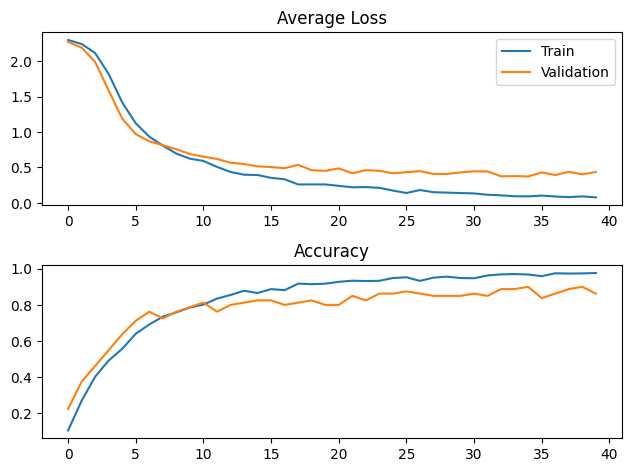

Test accuracy: 0.93
Fold 2:


Epoch 39: 100%|██████████| 40/40 [00:55<00:00,  1.39s/it, loss=0.0975, train_acc=0.962, val_acc=0.938]


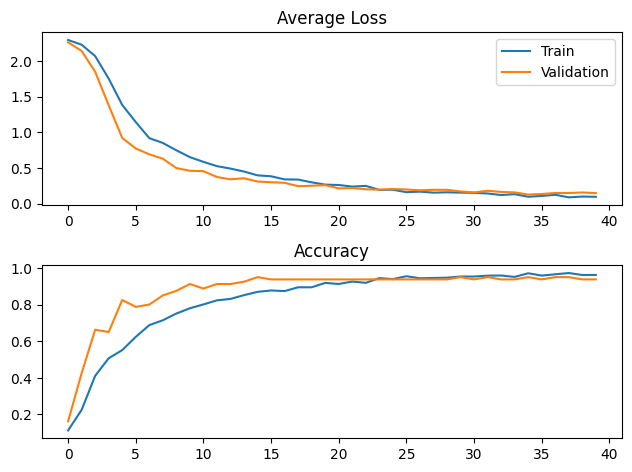

Test accuracy: 0.91
Fold 3:


Epoch 39: 100%|██████████| 40/40 [02:19<00:00,  3.49s/it, loss=0.0953, train_acc=0.969, val_acc=0.887]


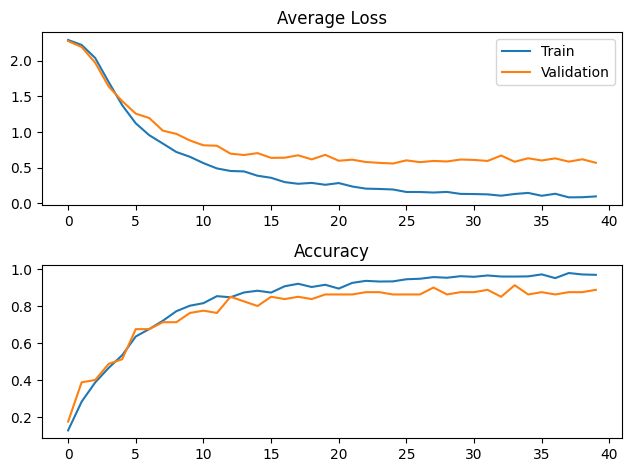

Test accuracy: 0.91
Fold 4:


Epoch 39: 100%|██████████| 40/40 [00:57<00:00,  1.43s/it, loss=0.107, train_acc=0.968, val_acc=0.925] 


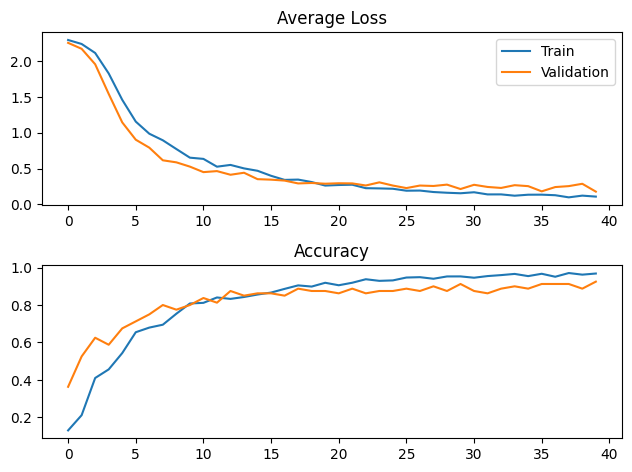

Test accuracy: 0.94
Fold 5:


Epoch 39: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, loss=0.0862, train_acc=0.969, val_acc=0.9]  


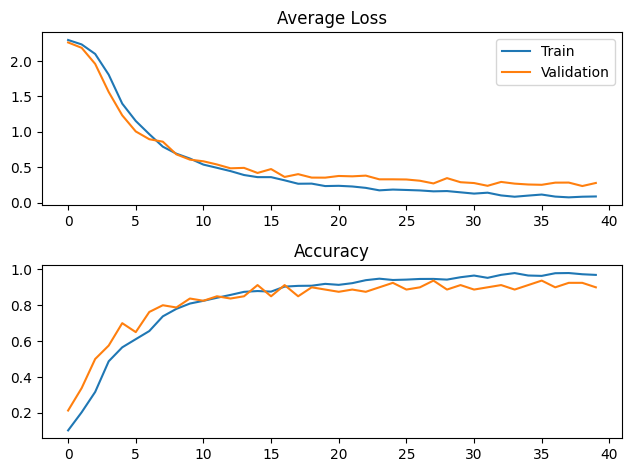

Test accuracy: 0.9045226130653267
Average Accuracy: 0.9189045226130654


,Accuracy
Fold 1,0.930000
Fold 2,0.910000
Fold 3,0.910000
Fold 4,0.940000
Fold 5,0.904523
Average,0.918905


In [33]:
# Perform K-Fold cross validation to evaluate the performance of the model
# The train function will produce a plot of the training/testing loss and accuracy.

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


kf = KFold(n_splits=5,shuffle=True)
results={}
ave_acc = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i+1}:")
    cnn = CNN(32, 64, 128)
    cnn.train()
    train(X[train_index], y[train_index], cnn,epoch=40, batch=128, lr=0.001)
    
    cnn.eval()
    pred=[x.argmax().item() for x in cnn(torch.tensor(X[test_index],dtype=torch.float32))]
    acc=accuracy_score(pred, y[test_index])
    ave_acc.append(acc)
    results[f"Fold {i+1}"] = acc
    print(f"Test accuracy: {acc}")

average_acc = np.mean(ave_acc)
results["Average"] = average_acc
print('Average Accuracy: {}'.format(average_acc))

pd.DataFrame([results], index=["Accuracy"]).T